<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/DHOD/blob/master/nb/Zheng2007_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Zheng2007 in diffhod 
This notebook illustrates how to implenent Zheng2007, and compare the results to halotools

## Preliminary setup


Here we download and install all the requirements

In [0]:
!pip install halotools
!download_initial_halocat.py 
!pip install --upgrade git+https://github.com/DifferentiableUniverseInitiative/DHOD.git@issue/12

In [1]:
%pylab inline
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow_probability import edward2 as ed
from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, NFWProfile
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

/usr/local/lib/python3.6/dist-packages/diffhod/components.py:9: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  logMmin=ed.Deterministic(11.35, name='logMmin'),


## Prepare halo catalog

In [0]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

## Model definition

In [0]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', 
                                        redshift =-0.003, 
                                        modulate_with_cenocc=True)

In [0]:
# Here is how we define the same model in diffhod
@tf.function
def hod(halo_cat, max_sat=40, temp=0.1):

  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      **zheng07_model.param_dict,
                      temperature=temp)
  
  n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
                                      n_cen,
                                      **zheng07_model.param_dict,
                                      sample_shape=(max_sat,),
                                      temperature=temp)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                        halo_cat['halo_y'],
                                        halo_cat['halo_z']], axis=-1))
  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                        concentration=halo_cat['halo_nfw_conc'],
                        Rvir=halo_cat['halo_rvir'],
                        sample_shape=(max_sat,))
  
  return {'pos_cen':pos_cen, 'pos_sat':pos_sat, 'n_cen':n_cen, 'n_sat':n_sat}

In [0]:
# sampling galaxies from the model
gal_cat = hod(tf_halocat)

In [0]:
# Same thing with halotools
zheng07_model.populate_mock(halocat) 

## Testing 2pt function

In [0]:
# Let's define halotools samples
ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                       zheng07_model.mock.galaxy_table['y'],
                                       zheng07_model.mock.galaxy_table['z'])
m = zheng07_model.mock.galaxy_table['host_centric_distance'] <0.0001
ht_cens = ht_sample[m]
ht_sats = ht_sample[~m]

In [0]:
# Same thing for dhod
p = gal_cat['n_cen']>0.5
tf_cens = gal_cat['pos_cen'][p].numpy()
p = gal_cat['n_sat']>0.5
tf_sats = gal_cat['pos_sat'][p].numpy().reshape((-1,3))
tf_sample = np.concatenate([tf_cens, tf_sats], axis=0)

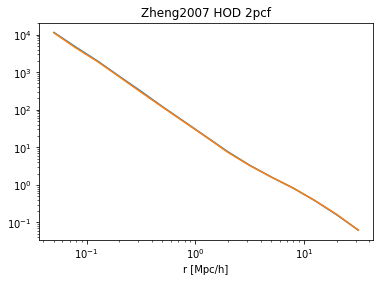

In [67]:
rbins = np.logspace(-1.5, 1.5, 16)
xi_ht = tpcf(ht_sample, rbins, period=halocat.Lbox)
xi_tf = tpcf(tf_sample, rbins, period=halocat.Lbox)

loglog(rbins[1:],xi_ht, label='halotools')
loglog(rbins[1:],xi_tf, label='DHOD')
xlabel('r [Mpc/h]')
title('Zheng2007 HOD 2pcf');

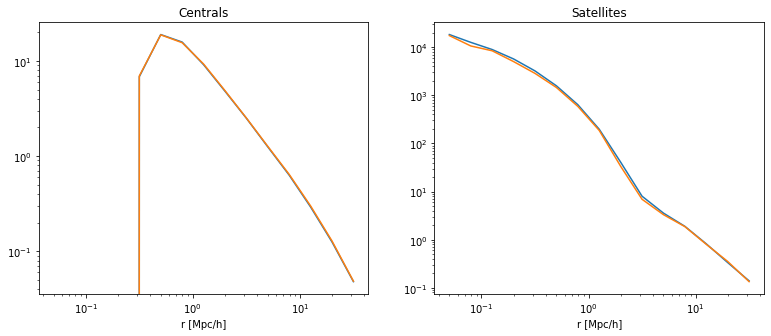

In [68]:
xi_ht_cen = tpcf(ht_cens, rbins, period=halocat.Lbox)
xi_tf_cen = tpcf(tf_cens, rbins, period=halocat.Lbox)
xi_ht_sat = tpcf(ht_sats, rbins, period=halocat.Lbox)
xi_tf_sat = tpcf(tf_sats, rbins, period=halocat.Lbox)

figure(figsize=(13,5))
subplot(121)
loglog(rbins[1:],xi_ht_cen, label='halotools')
loglog(rbins[1:],xi_tf_cen, label='DHOD')
xlabel('r [Mpc/h]')
title('Centrals');

subplot(122)
loglog(rbins[1:],xi_ht_sat, label='halotools')
loglog(rbins[1:],xi_tf_sat, label='DHOD')
xlabel('r [Mpc/h]')
title('Satellites');